In [1]:
# Makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

from IPython.display import display, Latex, clear_output
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import S, source_spectrum
# from pynrc.obs_nircam import model_to_hdulist, obs_hci
# from pynrc.obs_nircam import plot_contrasts, plot_contrasts_mjup, planet_mags, plot_planet_patches

pynrc.setup_logging('WARNING', verbose=False)

[     pynrc:INFO]   jwst_backgrounds is not installed and will not be used for bg estimates.


In [3]:
# Observation Definitions
from pynrc.nb_funcs import make_key, model_info, obs_wfe, obs_optimize

# Functions to run a series of operations
from pynrc.nb_funcs import do_opt, do_contrast, do_gen_hdus, do_sat_levels

# Plotting routines
from pynrc.nb_funcs import do_plot_contrasts, plot_images, plot_images_swlw, do_plot_contrasts2

## Define Sources and their Reference PSF Stars

In [4]:
# Various Bandpasses
bp_v = S.ObsBandpass('v')
bp_k = pynrc.bp_2mass('k')
bp_w1 = pynrc.bp_wise('w1')
bp_w2 = pynrc.bp_wise('w2')

In [5]:
#                source,      dist, age, sptype, Teff, [Fe/H], log_g, mag, band, fov
args_sources = [('HD10647',  17.34, 1400, 'F9V', 5954, +0.00, 4.7, 4.34, bp_k, 13),
                ('HD107146', 27.47,  200, 'G2V', 5850, +0.00, 4.5, 5.54, bp_k, 13),
                ('HD181327', 48.21,   12, 'F6V', 6449, +0.29, 4.4, 5.91, bp_k,  7),
                ('HD61005',  36.49,  100, 'G8V', 5500, +0.00, 4.5, 6.45, bp_k,  7),
                ('HD32297', 132.79,   30, 'A7V', 7800, -0.76, 3.8, 7.59, bp_k,  5),
               ]

ref_sources  = [('iotHor',   'F8V',  6080, +0.15, 4.5, 4.14, bp_k),
                ('HD111398', 'G5V',  5689, +0.07, 4.5, 5.53, bp_k),
                ('HR7297',   'F7V',  6500, -0.10, 4.2, 5.10, bp_k),
                ('HD56161',  'G5IV', 5337, +0.00, 4.3, 4.91, bp_k),
                ('HD31411',  'A0V',  9500, +0.00, 4.0, 6.42, bp_k)]

In [6]:
# Directory housing VOTables 
# http://vizier.u-strasbg.fr/vizier/sed/
votdir = 'votables/'

# Directory to save plots and figures
outdir  = 'DebrisDisks/'

In [7]:
# List of filters
args_filter = [('F300M', 'MASK335R', 'CIRCLYOT'),
               #('F335M', 'MASK335R', 'CIRCLYOT'),
               ('F444W', 'MASK335R', 'CIRCLYOT')]

subsize = 320

#args_filter = [('F335M', 'MASK335R', 'CIRCLYOT'),
#               ('F444W', 'MASK335R', 'CIRCLYOT')]

filt_keys = []
for filt,mask,pupil in args_filter:
    filt_keys.append(make_key(filt, mask=mask, pupil=pupil)) 

In [8]:
save_figs = True

## HD 10647

In [9]:
# Fit spectrum to SED photometry
i=0
name_sci, dist_sci, age, spt_sci, Teff_sci, feh_sci, logg_sci, mag_sci, bp_sci, fov = args_sources[i]
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
kwargs = {'Teff':Teff_sci, 'metallicity':feh_sci, 'log_g':logg_sci}
src = source_spectrum(*args, **kwargs)

src.fit_SED(use_err=False, robust=True, wlim=[1,4])

# Final source spectrum
sp_sci = src.sp_model

Warning, 1 of 43 bins contained negative fluxes; they have been set to zero.
[1.0135502]


In [10]:
# Do the same for the reference source
name_ref, spt_ref, Teff_ref, feh_ref, logg_ref, mag_ref, bp_ref = ref_sources[i]
vot = votdir + name_ref.replace(' ' ,'') + '.vot'

args = (name_ref, spt_ref, mag_ref, bp_ref, vot)
kwargs = {'Teff':Teff_ref, 'metallicity':feh_ref, 'log_g':logg_ref}
ref = nrc_utils.source_spectrum(*args, **kwargs)

ref.fit_SED(use_err=True, robust=True)

# Final reference spectrum
sp_ref = ref.sp_model

Warning, 1 of 31 bins contained negative fluxes; they have been set to zero.
[1.01410814]


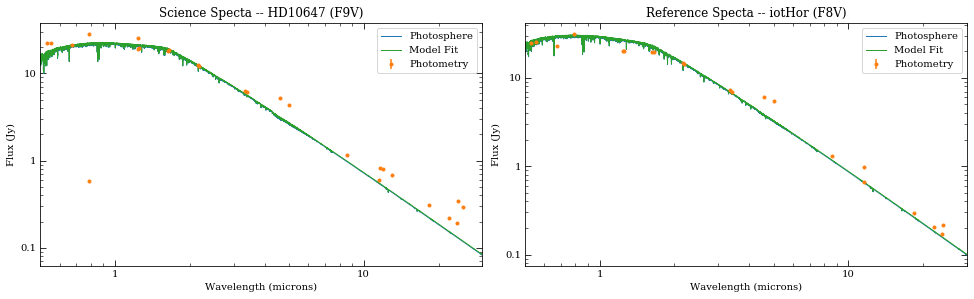

In [11]:
# Plot spectra 

fig, axes = plt.subplots(1,2, figsize=(14,4.5))
src.plot_SED(ax=axes[0], xr=[0.5,30])
ref.plot_SED(ax=axes[1], xr=[0.5,30])

axes[0].set_title('Science Specta -- {} ({})'.format(src.name, spt_sci))
axes[1].set_title('Reference Specta -- {} ({})'.format(ref.name, spt_ref))

#for ax in axes:
#    ax.set_xscale('linear')
#    ax.xaxis.set_minor_locator(AutoMinorLocator())

fig.tight_layout()
fig.subplots_adjust(top=0.85, bottom=0.1 , left=0.05, right=0.97)

if save_figs: 
    fig.savefig(outdir+'{}_SEDs.pdf'.format(name_sci.replace(' ','')))

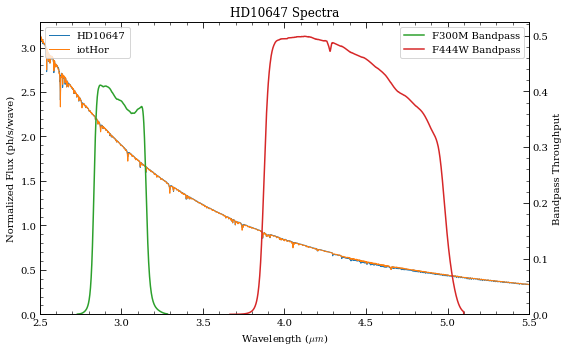

In [12]:
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plot the two spectra with bandpasses
fig, ax = plt.subplots(1,1, figsize=(8,5))

xr = [2.5,5.5]

for sp in [sp_sci, sp_ref]:
    w = sp.wave / 1e4
    ind = (w>=xr[0]) & (w<=xr[1])
    ind2 = (w>=3) & (w<=5)
    sp.convert('photlam')
    f = sp.flux / np.mean(sp.flux[ind2])
    ax.plot(w[ind], f[ind], lw=1, label=sp.name)
    
    sp.convert('flam')

    
ax.set_xlim(xr)
ax.set_ylim([0,ax.get_ylim()[1]])
ax.set_xlabel(r'Wavelength ($\mu m$)')
ax.set_ylabel(r'Normalized Flux (ph/s/wave)')
ax.set_title('{} Spectra'.format(sp_sci.name))

# Overplot Filter Bandpass
ax2 = ax.twinx()
for i, af in enumerate(args_filter):
    bp = pynrc.read_filter(*af)
    ax2.plot(bp.wave/1e4, bp.throughput, color=cols[i+2], label=bp.name+' Bandpass')
ax2.set_ylim([0,ax2.get_ylim()[1]])
ax2.set_xlim(xr)
ax2.set_ylabel('Bandpass Throughput')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()
if save_figs:
    fig.savefig(outdir+'{}_SEDs_bps.pdf'.format(name_sci.replace(' ','')))

In [13]:
# Create a dictionary that holds the obs_coronagraphy class for each filter
wfe_drift = 0
obs_dict = obs_wfe(wfe_drift, args_filter, sp_sci, dist_sci, sp_ref=sp_ref, args_disk='auto', 
                   wind_mode='WINDOW', subsize=subsize, verbose=False)

F300M_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT


In [14]:
# Optimize readout parameters
tacq = 4200
# patterns=['BRIGHT2', 'SHALLOW4', 'MEDIUM8']
# do_opt(tacq, patterns=patterns, ng_min=5, ng_max=10, tacq_frac=0.1, well_levels=[2], even_nints=True)

In [15]:
# Update multiaccum info
for key in filt_keys:
    obs = obs_dict[key]

    read_mode='MEDIUM8'
    ng, nint_sci, nint_ref = (8,21,20)
    # Double up for SW, because fewer number of paired fitlers
    if obs.bandpass.avgwave()/1e4 < 2.5: 
        nint_sci *= 2
        nint_ref *= 2
    
    obs.update_detectors(read_mode=read_mode, ngroup=ng, nint=nint_sci)
    obs.nrc_ref.update_detectors(read_mode=read_mode, ngroup=ng, nint=nint_ref)

#     print(key)
#     print(obs.multiaccum_times)
#     _ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
#     print('')


In [16]:
sat_dict = {}

for k in filt_keys:
    print('\n{}'.format(k))
    obs = obs_dict[k]
    
    dsat_asec = do_sat_levels(obs, satval=0.9, plot=False)
    sat_dict[k] = dsat_asec


F300M_MASK335R_CIRCLYOT
Sci: HD10647
  0 saturated pixel at NGROUP=2; Max Well: 0.23
  1 saturated pixel at NGROUP=8; Max Well: 0.99
  Sat Dist NG=2: 0.00 arcsec
Ref: iotHor
  0 saturated pixel at NGROUP=2; Max Well: 0.27
  8 saturated pixel at NGROUP=8; Max Well: 1.19

F444W_MASK335R_CIRCLYOT
Sci: HD10647
  0 saturated pixel at NGROUP=2; Max Well: 0.12
  0 saturated pixel at NGROUP=8; Max Well: 0.52
  Sat Dist NG=2: 0.00 arcsec
Ref: iotHor
  0 saturated pixel at NGROUP=2; Max Well: 0.15
  0 saturated pixel at NGROUP=8; Max Well: 0.63


In [17]:
# Disk Images
wfe_drift = 3
wfe_roll_drift = 1
hdu_dict = do_gen_hdus(obs_dict, filt_keys, wfe_drift, wfe_roll_drift, 
                       PA1=-5, PA2=+5, opt_diff=False, use_cmask=True,
                       verbose=True)

# Save FITS files
for k in filt_keys:
    hdul = hdu_dict[k]
    if save_figs: hdul.writeto(outdir+'{}_{}.fits'.format(name_sci,k), overwrite=True)

F300M_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT


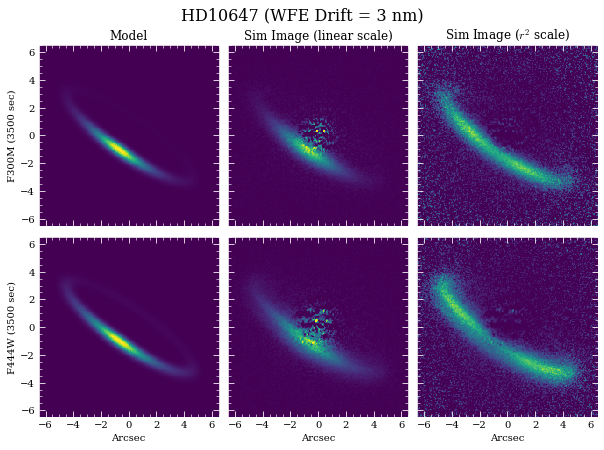

In [18]:
if len(filt_keys)==2:
    plot_images(obs_dict, hdu_dict, filt_keys, wfe_drift, fov=fov, save_fig=save_figs, outdir=outdir)
else:
    plot_images_swlw(obs_dict, hdu_dict, filt_keys, wfe_drift, fov=fov, save_fig=save_figs, outdir=outdir)

In [19]:
# Determine contrast curves for various WFE drift values
wfe_list = [0,2,5,10]
nsig = 5
roll = 10

# (Roll1 - Ref) + (Roll2 - Ref)
curves_ref = do_contrast(obs_dict, wfe_list, filt_keys[-1:], nsig=nsig, roll_angle=roll, opt_diff=False, 
                         exclude_disk=False)

# (Roll1 - Roll2) + (Roll2 - Roll1)
curves_roll = do_contrast(obs_dict, wfe_list, filt_keys[-1:], nsig=nsig, roll_angle=roll, opt_diff=False, 
                          exclude_disk=False, no_ref=True)

F444W_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT


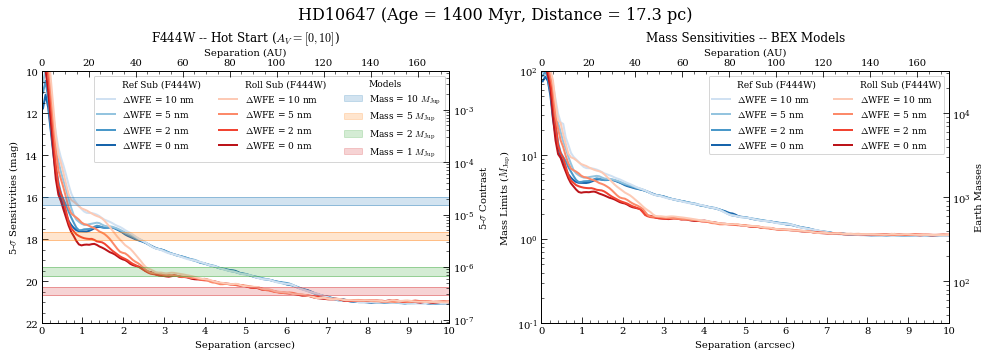

In [20]:
for k in filt_keys[-1:]:
    key1 = key2 = k
    lab1 = 'Ref Sub ({})'.format(obs_dict[k].filter)
    lab2 = 'Roll Sub ({})'.format(obs_dict[k].filter)
    fig, axes_all = do_plot_contrasts2(key1, key2, curves_ref, nsig, obs_dict, wfe_list, age,
                                       sat_dict=sat_dict, label1=lab1, label2=lab2, yr=[22,10],
                                       yscale2='log', yr2=[1e-1, 100], curves_all2=curves_roll)

    fname = "{}_{}.pdf".format(name_sci.replace(" ", ""), k)
    if save_figs: 
        fig.savefig(outdir+fname)

## HD 107146

In [21]:
# Fit spectrum to SED photometry
i=1
name_sci, dist_sci, age, spt_sci, Teff_sci, feh_sci, logg_sci, mag_sci, bp_sci, fov = args_sources[i]
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
kwargs = {'Teff':Teff_sci, 'metallicity':feh_sci, 'log_g':logg_sci}
src = source_spectrum(*args, **kwargs)

src.fit_SED(use_err=False, robust=True, wlim=[1,4])

# Final source spectrum
sp_sci = src.sp_model

[1.00911793]


In [22]:
# Do the same for the reference source
name_ref, spt_ref, Teff_ref, feh_ref, logg_ref, mag_ref, bp_ref = ref_sources[i]
vot = votdir + name_ref.replace(' ' ,'') + '.vot'

args = (name_ref, spt_ref, mag_ref, bp_ref, vot)
kwargs = {'Teff':Teff_ref, 'metallicity':feh_ref, 'log_g':logg_ref}
ref = nrc_utils.source_spectrum(*args, **kwargs)

ref.fit_SED(use_err=True, robust=True)

# Final reference spectrum
sp_ref = ref.sp_model

[1.04390456]


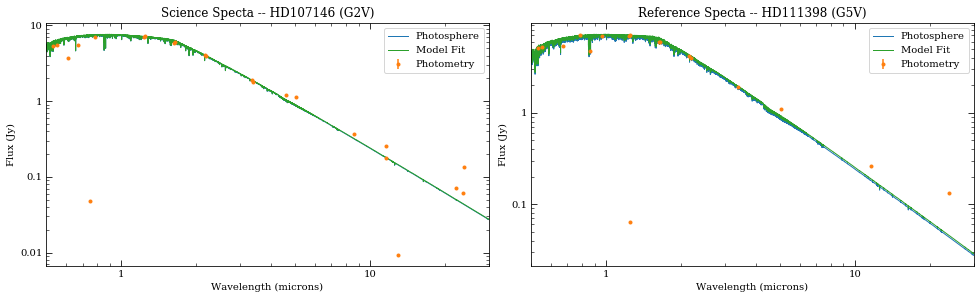

In [23]:
# Plot spectra 

fig, axes = plt.subplots(1,2, figsize=(14,4.5))
src.plot_SED(ax=axes[0], xr=[0.5,30])
ref.plot_SED(ax=axes[1], xr=[0.5,30])

axes[0].set_title('Science Specta -- {} ({})'.format(src.name, spt_sci))
axes[1].set_title('Reference Specta -- {} ({})'.format(ref.name, spt_ref))

#for ax in axes:
#    ax.set_xscale('linear')
#    ax.xaxis.set_minor_locator(AutoMinorLocator())

fig.tight_layout()
fig.subplots_adjust(top=0.85, bottom=0.1 , left=0.05, right=0.97)

if save_figs: 
    fig.savefig(outdir+'{}_SEDs.pdf'.format(name_sci.replace(' ','')))

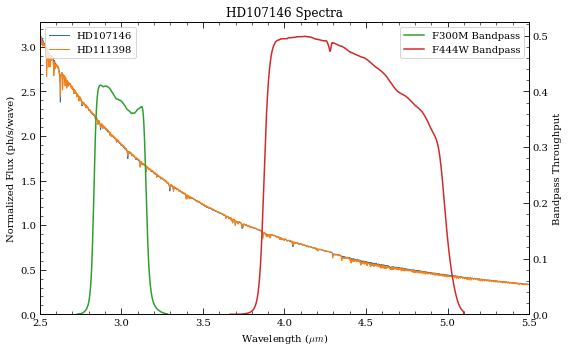

In [24]:
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plot the two spectra with bandpasses
fig, ax = plt.subplots(1,1, figsize=(8,5))

xr = [2.5,5.5]

for sp in [sp_sci, sp_ref]:
    w = sp.wave / 1e4
    ind = (w>=xr[0]) & (w<=xr[1])
    ind2 = (w>=3) & (w<=5)
    sp.convert('photlam')
    f = sp.flux / np.mean(sp.flux[ind2])
    sp.convert('flam')
    ax.plot(w[ind], f[ind], lw=1, label=sp.name)
    
ax.set_xlim(xr)
ax.set_ylim([0,ax.get_ylim()[1]])
ax.set_xlabel(r'Wavelength ($\mu m$)')
ax.set_ylabel(r'Normalized Flux (ph/s/wave)')
ax.set_title('{} Spectra'.format(sp_sci.name))

# Overplot Filter Bandpass
ax2 = ax.twinx()
for i, af in enumerate(args_filter):
    bp = pynrc.read_filter(*af)
    ax2.plot(bp.wave/1e4, bp.throughput, color=cols[i+2], label=bp.name+' Bandpass')
ax2.set_ylim([0,ax2.get_ylim()[1]])
ax2.set_xlim(xr)
ax2.set_ylabel('Bandpass Throughput')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()
if save_figs:
    fig.savefig(outdir+'{}_SEDs_bps.pdf'.format(name_sci.replace(' ','')))

In [25]:
# Create a dictionary that holds the obs_coronagraphy class for each filter
wfe_drift = 0
obs_dict = obs_wfe(wfe_drift, args_filter, sp_sci, dist_sci, sp_ref=sp_ref, args_disk='auto', 
                   wind_mode='WINDOW', subsize=subsize, verbose=False)

F300M_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT


In [26]:
# Optimize readout parameters
tacq = 4200
#do_opt(tacq, patterns='MEDIUM8', ng_min=8, ng_max=8, tacq_frac=0.1, well_levels=[2], even_nints=True)

In [27]:
for key in filt_keys:
    obs = obs_dict[key]

    read_mode='MEDIUM8'
    ng, nint_sci, nint_ref = (10,17,15)
    if obs.bandpass.avgwave()/1e4 < 2.5: 
        nint_sci *= 2
        nint_ref *= 2
    
    obs.update_detectors(read_mode=read_mode, ngroup=ng, nint=nint_sci)
    obs.nrc_ref.update_detectors(read_mode=read_mode, ngroup=ng, nint=nint_ref)

    #print(key)
    #print(obs.multiaccum_times)
    #_ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
    #print('')


In [28]:
sat_dict = {}

for k in filt_keys:
    print('\n{}'.format(k))
    obs = obs_dict[k]
    
    dsat_asec = do_sat_levels(obs, satval=0.9, plot=False)
    sat_dict[k] = dsat_asec


F300M_MASK335R_CIRCLYOT
Sci: HD107146
  0 saturated pixel at NGROUP=2; Max Well: 0.08
  0 saturated pixel at NGROUP=10; Max Well: 0.41
  Sat Dist NG=2: 0.00 arcsec
Ref: HD111398
  0 saturated pixel at NGROUP=2; Max Well: 0.08
  0 saturated pixel at NGROUP=10; Max Well: 0.43

F444W_MASK335R_CIRCLYOT
Sci: HD107146
  0 saturated pixel at NGROUP=2; Max Well: 0.04
  0 saturated pixel at NGROUP=10; Max Well: 0.22
  Sat Dist NG=2: 0.00 arcsec
Ref: HD111398
  0 saturated pixel at NGROUP=2; Max Well: 0.04
  0 saturated pixel at NGROUP=10; Max Well: 0.22


In [29]:
# Disk Images
wfe_drift = 3
wfe_roll_drift = 1
hdu_dict = do_gen_hdus(obs_dict, filt_keys, wfe_drift, wfe_roll_drift, 
                       PA1=-5, PA2=+5, opt_diff=False, use_cmask=True,
                       verbose=True)

F300M_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT


In [30]:
# Save FITS files
for k in filt_keys:
    hdul = hdu_dict[k]
    if save_figs: 
        hdul.writeto(outdir+'{}_{}.fits'.format(name_sci,k), overwrite=True)

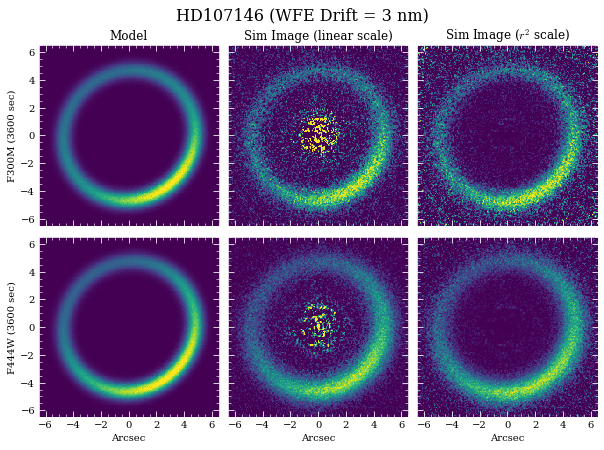

In [31]:
if len(filt_keys)==2:
    plot_images(obs_dict, hdu_dict, filt_keys, wfe_drift, fov=fov, save_fig=save_figs, outdir=outdir)
else:
    plot_images_swlw(obs_dict, hdu_dict, filt_keys, wfe_drift, fov=fov, save_fig=save_figs, outdir=outdir)

In [32]:
# Determine contrast curves for various WFE drift values
wfe_list = [0,2,5,10]
nsig = 5
roll = 10

# (Roll1 - Ref) + (Roll2 - Ref)
curves_ref = do_contrast(obs_dict, wfe_list, filt_keys[-1:], nsig=nsig, roll_angle=roll, opt_diff=False, 
                         exclude_disk=False)

# (Roll1 - Roll2) + (Roll2 - Roll1)
curves_roll = do_contrast(obs_dict, wfe_list, filt_keys[-1:], nsig=nsig, roll_angle=roll, opt_diff=False, 
                          exclude_disk=False, no_ref=True)

F444W_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT


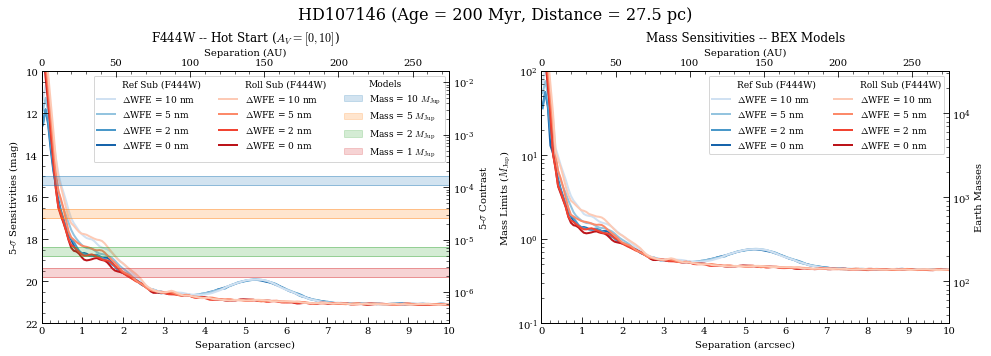

In [33]:
for k in filt_keys[-1:]:
    key1 = key2 = k
    lab1 = 'Ref Sub ({})'.format(obs_dict[k].filter)
    lab2 = 'Roll Sub ({})'.format(obs_dict[k].filter)
    fig, axes_all = do_plot_contrasts2(key1, key2, curves_ref, nsig, obs_dict, wfe_list, age, 
                                       sat_dict=sat_dict, label1=lab1, label2=lab2, yr=[22,10],
                                       yscale2='log', yr2=[1e-1, 100], curves_all2=curves_roll)

    fname = "{}_{}.pdf".format(name_sci.replace(" ", ""), k)
    if save_figs: 
        fig.savefig(outdir+fname)

## HD 181327

In [34]:
# Fit spectrum to SED photometry

i=2
name_sci, dist_sci, age, spt_sci, Teff_sci, feh_sci, logg_sci, mag_sci, bp_sci, fov = args_sources[i]
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
kwargs = {'Teff':Teff_sci, 'metallicity':feh_sci, 'log_g':logg_sci}
src = source_spectrum(*args, **kwargs)

src.fit_SED(use_err=False, robust=True, wlim=[1,4])

# Final source spectrum
sp_sci = src.sp_model

[0.97349543]


In [35]:
# Do the same for the reference source
name_ref, spt_ref, Teff_ref, feh_ref, logg_ref, mag_ref, bp_ref = ref_sources[i]
vot = votdir + name_ref.replace(' ' ,'') + '.vot'

args = (name_ref, spt_ref, mag_ref, bp_ref, vot)
kwargs = {'Teff':Teff_ref, 'metallicity':feh_ref, 'log_g':logg_ref}
ref = nrc_utils.source_spectrum(*args, **kwargs)

ref.fit_SED(use_err=True, robust=True)

# Final reference spectrum
sp_ref = ref.sp_model

[0.92729568]


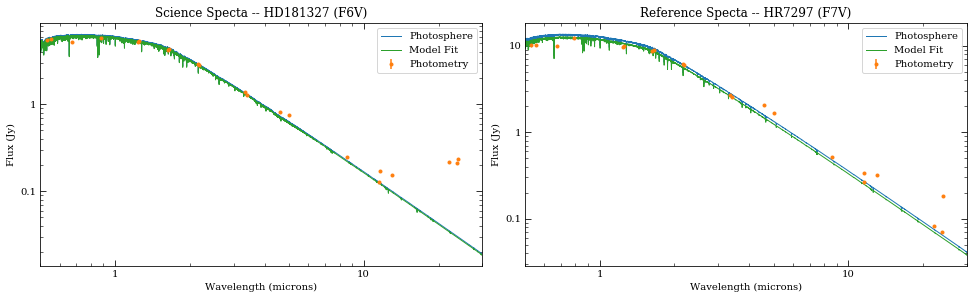

In [36]:
# Plot spectra 

fig, axes = plt.subplots(1,2, figsize=(14,4.5))
src.plot_SED(ax=axes[0], xr=[0.5,30])
ref.plot_SED(ax=axes[1], xr=[0.5,30])

axes[0].set_title('Science Specta -- {} ({})'.format(src.name, spt_sci))
axes[1].set_title('Reference Specta -- {} ({})'.format(ref.name, spt_ref))

#for ax in axes:
#    ax.set_xscale('linear')
#    ax.xaxis.set_minor_locator(AutoMinorLocator())

fig.tight_layout()
fig.subplots_adjust(top=0.85, bottom=0.1 , left=0.05, right=0.97)

if save_figs:
    fig.savefig(outdir+'{}_SEDs.pdf'.format(name_sci.replace(' ','')))

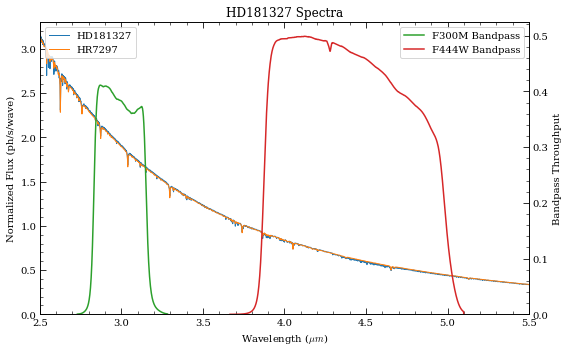

In [37]:
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plot the two spectra with bandpasses
fig, ax = plt.subplots(1,1, figsize=(8,5))

xr = [2.5,5.5]

for sp in [sp_sci, sp_ref]:
    w = sp.wave / 1e4
    ind = (w>=xr[0]) & (w<=xr[1])
    ind2 = (w>=3) & (w<=5)
    sp.convert('photlam')
    f = sp.flux / np.mean(sp.flux[ind2])
    sp.convert('flam')
    ax.plot(w[ind], f[ind], lw=1, label=sp.name)
    
ax.set_xlim(xr)
ax.set_ylim([0,ax.get_ylim()[1]])
ax.set_xlabel(r'Wavelength ($\mu m$)')
ax.set_ylabel(r'Normalized Flux (ph/s/wave)')
ax.set_title('{} Spectra'.format(sp_sci.name))

# Overplot Filter Bandpass
ax2 = ax.twinx()
for i, af in enumerate(args_filter):
    bp = pynrc.read_filter(*af)
    ax2.plot(bp.wave/1e4, bp.throughput, color=cols[i+2], label=bp.name+' Bandpass')
ax2.set_ylim([0,ax2.get_ylim()[1]])
ax2.set_xlim(xr)
ax2.set_ylabel('Bandpass Throughput')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()
if save_figs:
    fig.savefig(outdir+'{}_SEDs_bps.pdf'.format(name_sci.replace(' ','')))

In [38]:
# Create a dictionary that holds the obs_coronagraphy class for each filter
wfe_drift = 0
obs_dict = obs_wfe(wfe_drift, args_filter, sp_sci, dist_sci, sp_ref=sp_ref, args_disk='auto', 
                   wind_mode='WINDOW', subsize=subsize, verbose=False)

F300M_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT


In [39]:
# Optimize readout parameters
tacq = 4200
#do_opt(tacq, patterns='MEDIUM8', ng_min=8, ng_max=8, tacq_frac=0.1, well_levels=[2], even_nints=True)

In [40]:
for key in filt_keys:
    obs = obs_dict[key]

    read_mode='MEDIUM8'
    ng, nint_sci, nint_ref = (10,11,15)
    if obs.bandpass.avgwave()/1e4 < 2.5: 
        nint_sci *= 2
        nint_ref *= 2
    
    obs.update_detectors(read_mode=read_mode, ngroup=ng, nint=nint_sci)
    obs.nrc_ref.update_detectors(read_mode=read_mode, ngroup=ng, nint=nint_ref)

    #print(key)
    #print(obs.multiaccum_times)
    #_ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
    #print('')


In [41]:
sat_dict = {}

for k in filt_keys:
    print('\n{}'.format(k))
    obs = obs_dict[k]
    
    dsat_asec = do_sat_levels(obs, satval=0.9, plot=False)
    sat_dict[k] = dsat_asec


F300M_MASK335R_CIRCLYOT
Sci: HD181327
  0 saturated pixel at NGROUP=2; Max Well: 0.05
  0 saturated pixel at NGROUP=10; Max Well: 0.28
  Sat Dist NG=2: 0.00 arcsec
Ref: HR7297
  0 saturated pixel at NGROUP=2; Max Well: 0.10
  0 saturated pixel at NGROUP=10; Max Well: 0.56

F444W_MASK335R_CIRCLYOT
Sci: HD181327
  0 saturated pixel at NGROUP=2; Max Well: 0.03
  0 saturated pixel at NGROUP=10; Max Well: 0.15
  Sat Dist NG=2: 0.00 arcsec
Ref: HR7297
  0 saturated pixel at NGROUP=2; Max Well: 0.06
  0 saturated pixel at NGROUP=10; Max Well: 0.30


In [42]:
# Disk Images
wfe_drift = 3
wfe_roll_drift = 1
hdu_dict = do_gen_hdus(obs_dict, filt_keys, wfe_drift, wfe_roll_drift, 
                       PA1=-5, PA2=+5, opt_diff=False, use_cmask=True,
                       verbose=True)

F300M_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT


In [43]:
# Save FITS files
for k in filt_keys:
    hdul = hdu_dict[k]
    if save_figs: 
        hdul.writeto(outdir+'{}_{}.fits'.format(name_sci,k), overwrite=True)

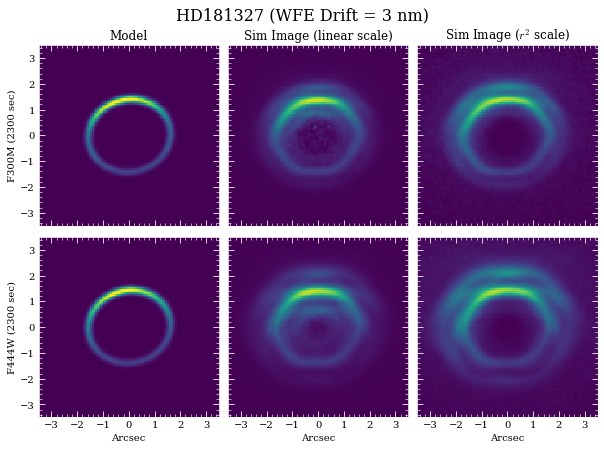

In [44]:
save_fig = True
if len(filt_keys)==2:
    plot_images(obs_dict, hdu_dict, filt_keys, wfe_drift, fov=fov, save_fig=save_fig, outdir=outdir)
else:
    plot_images_swlw(obs_dict, hdu_dict, filt_keys, wfe_drift, fov=fov, save_fig=save_fig, outdir=outdir)

In [45]:
# Determine contrast curves for various WFE drift values
wfe_list = [0,2,5,10]
nsig = 5
roll = 10

# (Roll1 - Ref) + (Roll2 - Ref)
curves_ref = do_contrast(obs_dict, wfe_list, filt_keys[-1:], nsig=nsig, roll_angle=roll, opt_diff=False, 
                         exclude_disk=False)

# (Roll1 - Roll2) + (Roll2 - Roll1)
curves_roll = do_contrast(obs_dict, wfe_list, filt_keys[-1:], nsig=nsig, roll_angle=roll, opt_diff=False, 
                          exclude_disk=False, no_ref=True)

F444W_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT


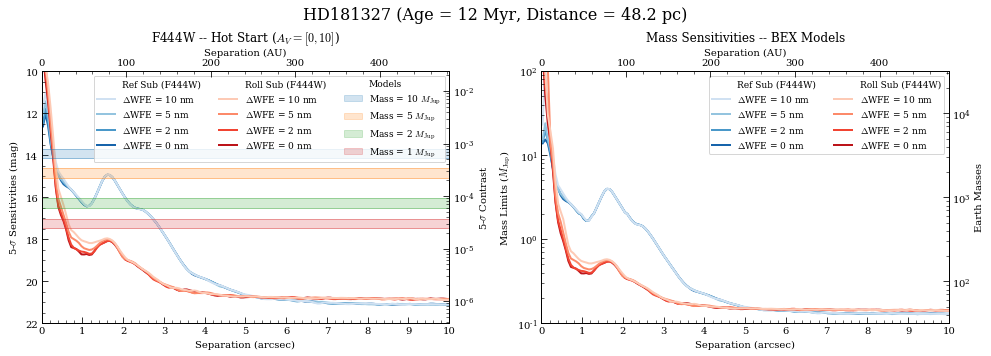

In [46]:
for k in filt_keys[-1:]:
    key1 = key2 = k
    lab1 = 'Ref Sub ({})'.format(obs_dict[k].filter)
    lab2 = 'Roll Sub ({})'.format(obs_dict[k].filter)
    fig, axes_all = do_plot_contrasts2(key1, key2, curves_ref, nsig, obs_dict, wfe_list, age, 
                                       sat_dict=sat_dict, label1=lab1, label2=lab2, yr=[22,10],
                                       yscale2='log', yr2=[1e-1, 100], curves_all2=curves_roll)

    fname = "{}_{}.pdf".format(name_sci.replace(" ", ""), k)
    if save_figs: 
        fig.savefig(outdir+fname)

## HD 61005

In [47]:
# Fit spectrum to SED photometry

i=3
name_sci, dist_sci, age, spt_sci, Teff_sci, feh_sci, logg_sci, mag_sci, bp_sci, fov = args_sources[i]
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
kwargs = {'Teff':Teff_sci, 'metallicity':feh_sci, 'log_g':logg_sci}
src = source_spectrum(*args, **kwargs)

src.fit_SED(use_err=False, robust=True, wlim=[1,4])

# Final source spectrum
sp_sci = src.sp_model

[0.96681562]


In [48]:
# Do the same for the reference source
name_ref, spt_ref, Teff_ref, feh_ref, logg_ref, mag_ref, bp_ref = ref_sources[i]
vot = votdir + name_ref.replace(' ' ,'') + '.vot'

args = (name_ref, spt_ref, mag_ref, bp_ref, vot)
kwargs = {'Teff':Teff_ref, 'metallicity':feh_ref, 'log_g':logg_ref}
ref = nrc_utils.source_spectrum(*args, **kwargs)

ref.fit_SED(use_err=True, robust=True)

# Final reference spectrum
sp_ref = ref.sp_model

[0.9238596]


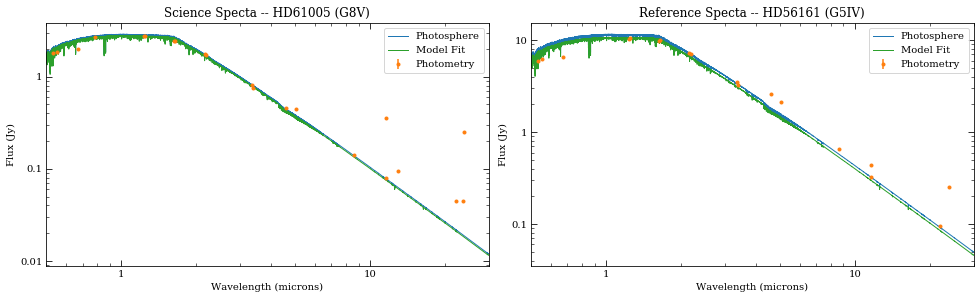

In [49]:
# Plot spectra 

fig, axes = plt.subplots(1,2, figsize=(14,4.5))
src.plot_SED(ax=axes[0], xr=[0.5,30])
ref.plot_SED(ax=axes[1], xr=[0.5,30])

axes[0].set_title('Science Specta -- {} ({})'.format(src.name, spt_sci))
axes[1].set_title('Reference Specta -- {} ({})'.format(ref.name, spt_ref))

#for ax in axes:
#    ax.set_xscale('linear')
#    ax.xaxis.set_minor_locator(AutoMinorLocator())

fig.tight_layout()
fig.subplots_adjust(top=0.85, bottom=0.1 , left=0.05, right=0.97)

if save_figs:
    fig.savefig(outdir+'{}_SEDs.pdf'.format(name_sci.replace(' ','')))

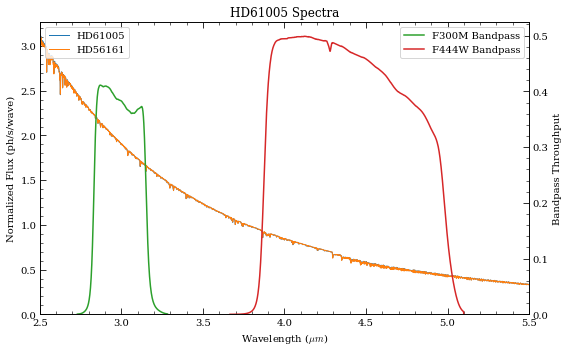

In [50]:
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plot the two spectra with bandpasses
fig, ax = plt.subplots(1,1, figsize=(8,5))

xr = [2.5,5.5]

for sp in [sp_sci, sp_ref]:
    w = sp.wave / 1e4
    ind = (w>=xr[0]) & (w<=xr[1])
    ind2 = (w>=3) & (w<=5)
    sp.convert('photlam')
    f = sp.flux / np.mean(sp.flux[ind2])
    sp.convert('flam')
    ax.plot(w[ind], f[ind], lw=1, label=sp.name)
    
ax.set_xlim(xr)
ax.set_ylim([0,ax.get_ylim()[1]])
ax.set_xlabel(r'Wavelength ($\mu m$)')
ax.set_ylabel(r'Normalized Flux (ph/s/wave)')
ax.set_title('{} Spectra'.format(sp_sci.name))

# Overplot Filter Bandpass
ax2 = ax.twinx()
for i, af in enumerate(args_filter):
    bp = pynrc.read_filter(*af)
    ax2.plot(bp.wave/1e4, bp.throughput, color=cols[i+2], label=bp.name+' Bandpass')
ax2.set_ylim([0,ax2.get_ylim()[1]])
ax2.set_xlim(xr)
ax2.set_ylabel('Bandpass Throughput')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()
if save_figs:
    fig.savefig(outdir+'{}_SEDs_bps.pdf'.format(name_sci.replace(' ','')))

In [51]:
# Create a dictionary that holds the obs_coronagraphy class for each filter
wfe_drift = 0
obs_dict = obs_wfe(wfe_drift, args_filter, sp_sci, dist_sci, sp_ref=sp_ref, args_disk='auto', 
                   wind_mode='WINDOW', subsize=subsize, verbose=False)

F300M_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT


In [52]:
# Optimize readout parameters
tacq = 4200
#do_opt(tacq, patterns='MEDIUM8', ng_min=8, ng_max=8, tacq_frac=0.1, well_levels=[2], even_nints=True)

In [53]:
for key in filt_keys:
    obs = obs_dict[key]

    read_mode='MEDIUM8'
    ng, nint_sci, nint_ref = (10,14,15)
    if obs.bandpass.avgwave()/1e4 < 2.5: 
        nint_sci *= 2
        nint_ref *= 2
    
    obs.update_detectors(read_mode=read_mode, ngroup=ng, nint=nint_sci)
    obs.nrc_ref.update_detectors(read_mode=read_mode, ngroup=ng, nint=nint_ref)

    #print(key)
    #print(obs.multiaccum_times)
    #_ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
    #print('')


In [54]:
sat_dict = {}

for k in filt_keys:
    print('\n{}'.format(k))
    obs = obs_dict[k]
    
    dsat_asec = do_sat_levels(obs, satval=0.9, plot=False)
    sat_dict[k] = dsat_asec


F300M_MASK335R_CIRCLYOT
Sci: HD61005
  0 saturated pixel at NGROUP=2; Max Well: 0.03
  0 saturated pixel at NGROUP=10; Max Well: 0.17
  Sat Dist NG=2: 0.00 arcsec
Ref: HD56161
  0 saturated pixel at NGROUP=2; Max Well: 0.12
  0 saturated pixel at NGROUP=10; Max Well: 0.67

F444W_MASK335R_CIRCLYOT
Sci: HD61005
  0 saturated pixel at NGROUP=2; Max Well: 0.02
  0 saturated pixel at NGROUP=10; Max Well: 0.09
  Sat Dist NG=2: 0.00 arcsec
Ref: HD56161
  0 saturated pixel at NGROUP=2; Max Well: 0.06
  0 saturated pixel at NGROUP=10; Max Well: 0.35


In [55]:
# Disk Images
wfe_drift = 3
wfe_roll_drift = 1
hdu_dict = do_gen_hdus(obs_dict, filt_keys, wfe_drift, wfe_roll_drift, 
                       PA1=-5, PA2=+5, opt_diff=False, use_cmask=True,
                       verbose=True)

F300M_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT


In [56]:
# Save FITS files
for k in filt_keys:
    hdul = hdu_dict[k]
    if save_figs:
        hdul.writeto(outdir+'{}_{}.fits'.format(name_sci,k), overwrite=True)

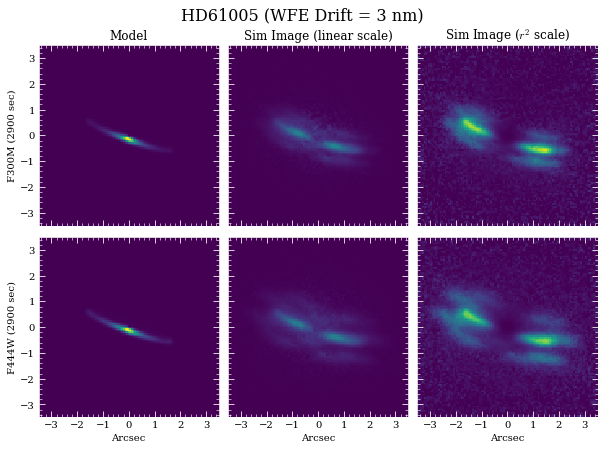

In [57]:
save_fig = True
if len(filt_keys)==2:
    plot_images(obs_dict, hdu_dict, filt_keys, wfe_drift, fov=fov, save_fig=save_fig, outdir=outdir)
else:
    plot_images_swlw(obs_dict, hdu_dict, filt_keys, wfe_drift, fov=fov, save_fig=save_fig, outdir=outdir)

In [58]:
# Determine contrast curves for various WFE drift values
wfe_list = [0,2,5,10]
nsig = 5
roll = 10

# (Roll1 - Ref) + (Roll2 - Ref)
curves_ref = do_contrast(obs_dict, wfe_list, filt_keys[-1:], nsig=nsig, roll_angle=roll, opt_diff=False, 
                         exclude_disk=False)

# (Roll1 - Roll2) + (Roll2 - Roll1)
curves_roll = do_contrast(obs_dict, wfe_list, filt_keys[-1:], nsig=nsig, roll_angle=roll, opt_diff=False, 
                          exclude_disk=False, no_ref=True)

F444W_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT


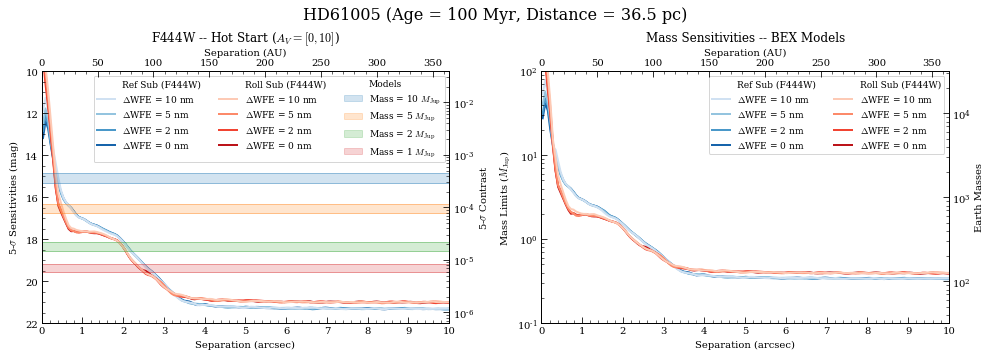

In [59]:
for k in filt_keys[-1:]:
    key1 = key2 = k
    lab1 = 'Ref Sub ({})'.format(obs_dict[k].filter)
    lab2 = 'Roll Sub ({})'.format(obs_dict[k].filter)
    fig, axes_all = do_plot_contrasts2(key1, key2, curves_ref, nsig, obs_dict, wfe_list, age, 
                                       sat_dict=sat_dict, label1=lab1, label2=lab2, yr=[22,10],
                                       yscale2='log', yr2=[1e-1, 100], curves_all2=curves_roll)

    fname = "{}_{}.pdf".format(name_sci.replace(" ", ""), k)
    if save_figs: 
        fig.savefig(outdir+fname)

## HD 32297

In [60]:
# Fit spectrum to SED photometry

i=4
name_sci, dist_sci, age, spt_sci, Teff_sci, feh_sci, logg_sci, mag_sci, bp_sci, fov = args_sources[i]
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
kwargs = {'Teff':Teff_sci, 'metallicity':feh_sci, 'log_g':logg_sci}
src = source_spectrum(*args, **kwargs)

src.fit_SED(use_err=False, robust=True, wlim=[1,4])

# Final source spectrum
sp_sci = src.sp_model

[0.99412904]


In [61]:
# Do the same for the reference source
name_ref, spt_ref, Teff_ref, feh_ref, logg_ref, mag_ref, bp_ref = ref_sources[i]
vot = votdir + name_ref.replace(' ' ,'') + '.vot'

args = (name_ref, spt_ref, mag_ref, bp_ref, vot)
kwargs = {'Teff':Teff_ref, 'metallicity':feh_ref, 'log_g':logg_ref}
ref = nrc_utils.source_spectrum(*args, **kwargs)

ref.fit_SED(use_err=True, robust=True)

# Final reference spectrum
sp_ref = ref.sp_model

[0.93365695]


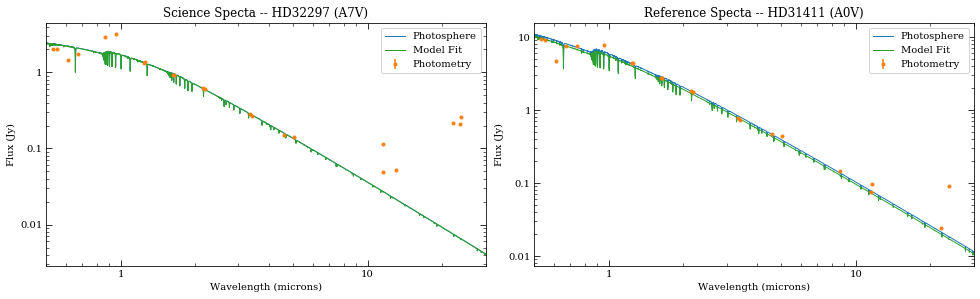

In [62]:
# Plot spectra 

fig, axes = plt.subplots(1,2, figsize=(14,4.5))
src.plot_SED(ax=axes[0], xr=[0.5,30])
ref.plot_SED(ax=axes[1], xr=[0.5,30])

axes[0].set_title('Science Specta -- {} ({})'.format(src.name, spt_sci))
axes[1].set_title('Reference Specta -- {} ({})'.format(ref.name, spt_ref))

#for ax in axes:
#    ax.set_xscale('linear')
#    ax.xaxis.set_minor_locator(AutoMinorLocator())

fig.tight_layout()
fig.subplots_adjust(top=0.85, bottom=0.1 , left=0.05, right=0.97)

fig.savefig(outdir+'{}_SEDs.pdf'.format(name_sci.replace(' ','')))

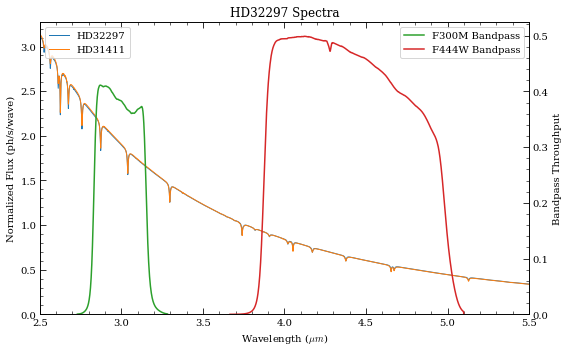

In [63]:
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plot the two spectra with bandpasses
fig, ax = plt.subplots(1,1, figsize=(8,5))

xr = [2.5,5.5]

for sp in [sp_sci, sp_ref]:
    w = sp.wave / 1e4
    ind = (w>=xr[0]) & (w<=xr[1])
    ind2 = (w>=3) & (w<=5)
    sp.convert('photlam')
    f = sp.flux / np.mean(sp.flux[ind2])
    sp.convert('flam')
    ax.plot(w[ind], f[ind], lw=1, label=sp.name)
    
ax.set_xlim(xr)
ax.set_ylim([0,ax.get_ylim()[1]])
ax.set_xlabel(r'Wavelength ($\mu m$)')
ax.set_ylabel(r'Normalized Flux (ph/s/wave)')
ax.set_title('{} Spectra'.format(sp_sci.name))

# Overplot Filter Bandpass
ax2 = ax.twinx()
for i, af in enumerate(args_filter):
    bp = pynrc.read_filter(*af)
    ax2.plot(bp.wave/1e4, bp.throughput, color=cols[i+2], label=bp.name+' Bandpass')
ax2.set_ylim([0,ax2.get_ylim()[1]])
ax2.set_xlim(xr)
ax2.set_ylabel('Bandpass Throughput')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()
if save_figs:
    fig.savefig(outdir+'{}_SEDs_bps.pdf'.format(name_sci.replace(' ','')))

In [64]:
# Create a dictionary that holds the obs_coronagraphy class for each filter
wfe_drift = 0
obs_dict = obs_wfe(wfe_drift, args_filter, sp_sci, dist_sci, sp_ref=sp_ref, args_disk='auto', 
                   wind_mode='WINDOW', subsize=subsize, verbose=False)

F300M_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT


In [65]:
# Optimize readout parameters
tacq = 4200
#do_opt(tacq, patterns='MEDIUM8', ng_min=8, ng_max=8, tacq_frac=0.1, well_levels=[2], even_nints=True)

In [66]:
for key in filt_keys:
    obs = obs_dict[key]

    read_mode='MEDIUM8'
    ng, nint_sci, nint_ref = (10,15,15)
    if obs.bandpass.avgwave()/1e4 < 2.5:
        nint_sci *= 2
        nint_ref *= 2
    
    obs.update_detectors(read_mode=read_mode, ngroup=ng, nint=nint_sci)
    obs.nrc_ref.update_detectors(read_mode=read_mode, ngroup=ng, nint=nint_ref)

    #print(key)
    #print(obs.multiaccum_times)
    #_ = obs.sensitivity(nsig=5, units='vegamag', verbose=True)
    #print('')


In [67]:
sat_dict = {}

for k in filt_keys:
    print('\n{}'.format(k))
    obs = obs_dict[k]
    
    dsat_asec = do_sat_levels(obs, satval=0.9, plot=False)
    sat_dict[k] = dsat_asec


F300M_MASK335R_CIRCLYOT
Sci: HD32297
  0 saturated pixel at NGROUP=2; Max Well: 0.01
  0 saturated pixel at NGROUP=10; Max Well: 0.06
  Sat Dist NG=2: 0.00 arcsec
Ref: HD31411
  0 saturated pixel at NGROUP=2; Max Well: 0.03
  0 saturated pixel at NGROUP=10; Max Well: 0.17

F444W_MASK335R_CIRCLYOT
Sci: HD32297
  0 saturated pixel at NGROUP=2; Max Well: 0.01
  0 saturated pixel at NGROUP=10; Max Well: 0.03
  Sat Dist NG=2: 0.00 arcsec
Ref: HD31411
  0 saturated pixel at NGROUP=2; Max Well: 0.02
  0 saturated pixel at NGROUP=10; Max Well: 0.09


In [68]:
# Disk Images
wfe_drift = 3
wfe_roll_drift = 1
hdu_dict = do_gen_hdus(obs_dict, filt_keys, wfe_drift, wfe_roll_drift, 
                       PA1=-5, PA2=+5, opt_diff=False, use_cmask=True,
                       verbose=True)

F300M_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT


In [69]:
# Save FITS files
for k in filt_keys:
    hdul = hdu_dict[k]
    if save_figs:
        hdul.writeto(outdir+'{}_{}.fits'.format(name_sci,k), overwrite=True)

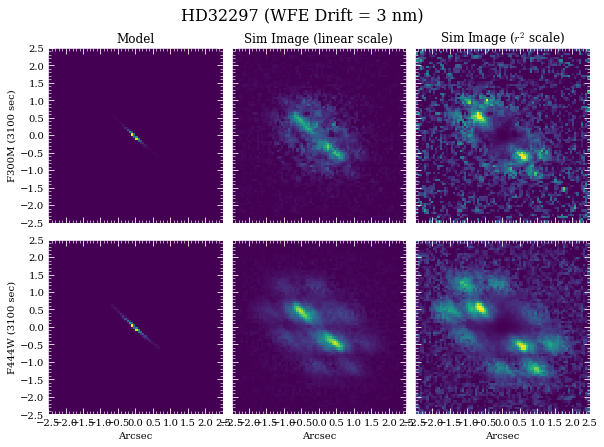

In [70]:
save_fig = True
if len(filt_keys)==2:
    plot_images(obs_dict, hdu_dict, filt_keys, wfe_drift, fov=fov, save_fig=save_fig, outdir=outdir)
else:
    plot_images_swlw(obs_dict, hdu_dict, filt_keys, wfe_drift, fov=fov, save_fig=save_fig, outdir=outdir)

In [71]:
# Determine contrast curves for various WFE drift values
wfe_list = [0,2,5,10]
nsig = 5
roll = 10

# (Roll1 - Ref) + (Roll2 - Ref)
curves_ref = do_contrast(obs_dict, wfe_list, filt_keys[-1:], nsig=nsig, roll_angle=roll, opt_diff=False, 
                         exclude_disk=False)

# (Roll1 - Roll2) + (Roll2 - Roll1)
curves_roll = do_contrast(obs_dict, wfe_list, filt_keys[-1:], nsig=nsig, roll_angle=roll, opt_diff=False, 
                          exclude_disk=False, no_ref=True)

F444W_MASK335R_CIRCLYOT
F444W_MASK335R_CIRCLYOT


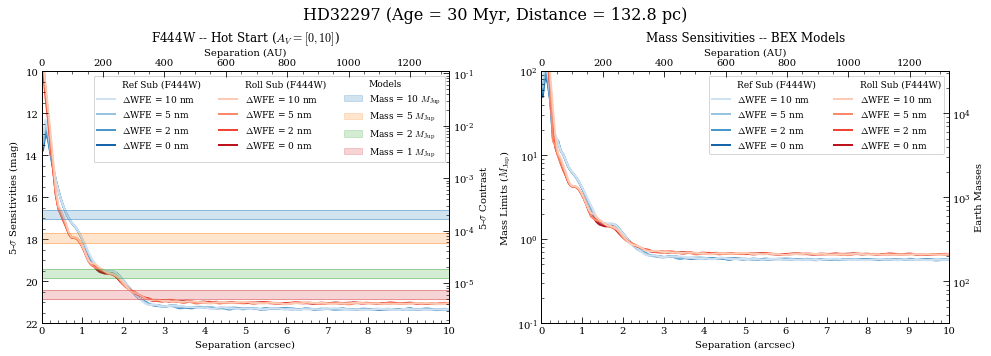

In [72]:
for k in filt_keys[-1:]:
    key1 = key2 = k
    lab1 = 'Ref Sub ({})'.format(obs_dict[k].filter)
    lab2 = 'Roll Sub ({})'.format(obs_dict[k].filter)
    fig, axes_all = do_plot_contrasts2(key1, key2, curves_ref, nsig, obs_dict, wfe_list, age, 
                                       sat_dict=sat_dict, label1=lab1, label2=lab2, yr=[22,10],
                                       yscale2='log', yr2=[1e-1, 100], curves_all2=curves_roll)

    fname = "{}_{}.pdf".format(name_sci.replace(" ", ""), k)
    if save_figs: 
        fig.savefig(outdir+fname)